In [5]:
from asyncio import get_event_loop
from websockets import serve
from matplotlib import pyplot as plt
from matplotlib import patches
from skimage import io, transform
from pylibdmtx.pylibdmtx import decode
from multiprocessing import Pool
from io import BytesIO
from json import dumps, loads, load
from uuid import uuid4
from math import cos, sin, pi
%matplotlib inline

In [6]:
from glob import glob
sorted(glob("../*"))

['../19b8bf0f-fce0-4c15-8d9b-07dc75a8fba4.json',
 '../19b8bf0f-fce0-4c15-8d9b-07dc75a8fba4.png',
 '../1a3587a4-2d09-497b-860b-bd5fd7f673c3.json',
 '../1a3587a4-2d09-497b-860b-bd5fd7f673c3.png',
 '../2af76b67-a2cd-44e1-b834-4532088e59a6.json',
 '../2af76b67-a2cd-44e1-b834-4532088e59a6.png',
 '../36d1f3f9-b830-4cb0-b3b0-8e58ebd70762.json',
 '../36d1f3f9-b830-4cb0-b3b0-8e58ebd70762.png',
 '../4084261f-3474-4371-b9b2-8920b6e7bbdd.json',
 '../4084261f-3474-4371-b9b2-8920b6e7bbdd.png',
 '../7d4f3876-dba3-463c-9944-cc39cec7604c.json',
 '../7d4f3876-dba3-463c-9944-cc39cec7604c.png',
 '../80e31bf5-e302-4e6f-9fcd-1f129a3c4cae.json',
 '../80e31bf5-e302-4e6f-9fcd-1f129a3c4cae.png',
 '../README.md',
 '../b8a57701-6252-41b2-a3b8-cd3c7f7a93d8.json',
 '../b8a57701-6252-41b2-a3b8-cd3c7f7a93d8.png',
 '../c4b0fc45-e867-49bf-b864-a65c9b9091ad.json',
 '../c4b0fc45-e867-49bf-b864-a65c9b9091ad.png',
 '../client',
 '../d2a96e9c-9bf9-409f-bd72-9edcf70655ba.json',
 '../d2a96e9c-9bf9-409f-bd72-9edcf70655ba.png',

In [99]:
filesets = [
    ['../19b8bf0f-fce0-4c15-8d9b-07dc75a8fba4.json', '../19b8bf0f-fce0-4c15-8d9b-07dc75a8fba4.png'],#0
    ['../1a3587a4-2d09-497b-860b-bd5fd7f673c3.json', '../1a3587a4-2d09-497b-860b-bd5fd7f673c3.png'],#1
 ['../2af76b67-a2cd-44e1-b834-4532088e59a6.json', '../2af76b67-a2cd-44e1-b834-4532088e59a6.png'],#2
 ['../36d1f3f9-b830-4cb0-b3b0-8e58ebd70762.json', '../36d1f3f9-b830-4cb0-b3b0-8e58ebd70762.png'],#3
 ['../4084261f-3474-4371-b9b2-8920b6e7bbdd.json', '../4084261f-3474-4371-b9b2-8920b6e7bbdd.png'],#4
 ['../7d4f3876-dba3-463c-9944-cc39cec7604c.json', '../7d4f3876-dba3-463c-9944-cc39cec7604c.png'],#5
 ['../80e31bf5-e302-4e6f-9fcd-1f129a3c4cae.json', '../80e31bf5-e302-4e6f-9fcd-1f129a3c4cae.png'],#6
 ['../b8a57701-6252-41b2-a3b8-cd3c7f7a93d8.json', '../b8a57701-6252-41b2-a3b8-cd3c7f7a93d8.png'],#7
 ['../c4b0fc45-e867-49bf-b864-a65c9b9091ad.json', '../c4b0fc45-e867-49bf-b864-a65c9b9091ad.png'],#8
 ['../d2a96e9c-9bf9-409f-bd72-9edcf70655ba.json', '../d2a96e9c-9bf9-409f-bd72-9edcf70655ba.png'],#9
]
fileset = 9

In [100]:
meta = load(open(filesets[fileset][0]))
grid = meta['grid']
iscale = meta['scale']
effort = 10

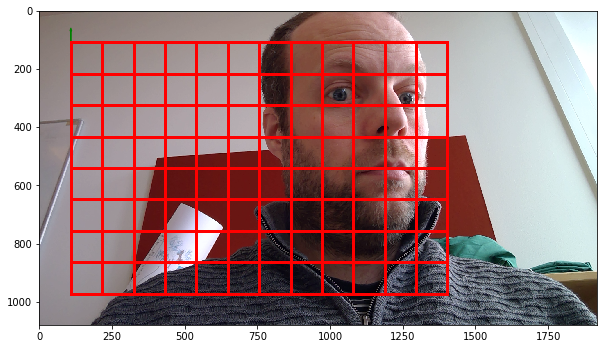

In [101]:
def decode_thread(pospos):
    col, xs, row, ys, well, effort = pospos
    return_package = {'row': row, 'xs': xs, 'col': col, 'ys': ys, 'barcode': 'failed'}
    if well.shape[0] > 0 and well.shape[1] > 0:
        res = decode(well, max_count=1)
        if res:
            return_package['barcode'] = res[0].data.decode()
        else:
            res = decode(well, timeout=1000, threshold=100, max_count=1)
            if res:
                return_package['barcode'] = res[0].data.decode()
    return return_package


im = io.imread(filesets[fileset][1])
scale = im.shape[1] / iscale
fig, ax = plt.subplots(1, figsize=(10, 20))
ax.imshow(im)
rect = patches.Rectangle((grid['left'] * scale, grid['top'] * scale), width=grid['width'] * grid['scaleX'] * scale,
                                                 height=grid['height'] * grid['scaleY'] * scale, angle=grid['angle'], linewidth=1,
                                                 edgecolor='r', facecolor='none')
ar_pa = patches.Arrow(grid['left'] * scale, grid['top'] * scale, cos(((grid['angle'] - 90) / 360) * (2 * pi)) * 50,
                                            sin(((grid['angle'] - 90) / 360) * (2 * pi)) * 50, color='green', width=10)
ax.add_patch(ar_pa)
ax.add_patch(rect)

if grid['width'] > grid['height']:
    grid_size = (grid['width'] / 12) * scale
    orientation = "landscape"
    no_rows = 8
    no_cols = 12
else:
    grid_size = (grid['height'] / 12) * scale
    orientation = "portrait"
    no_rows = 12
    no_cols = 8
width = grid_size * grid['scaleX']
height = grid_size * grid['scaleY']
ori_x = grid['left'] * scale
ori_y = grid['top'] * scale
angle = (grid['angle'] / 360) * 2 * pi
pps = []
for row in range(no_rows):
    for col in range(no_cols):
        dx1 = ori_x + width * col * cos(angle) - height * row * sin(angle)
        dx2 = ori_x + width * col * cos(angle) - height * (row + 1) * sin(angle)
        dx3 = ori_x + width * (col + 1) * cos(angle) - height * (row + 1) * sin(angle)
        dx4 = ori_x + width * (col + 1) * cos(angle) - height * row * sin(angle)
        dxs = [dx1, dx2, dx3, dx4]
        dy1 = ori_y + width * col * sin(angle) + height * row * cos(angle)
        dy2 = ori_y + width * col * sin(angle) + height * (row + 1) * cos(angle)
        dy3 = ori_y + width * (col + 1) * sin(angle) + height * (row + 1) * cos(angle)
        dy4 = ori_y + width * (col + 1) * sin(angle) + height * row * cos(angle)
        dys = [dy1, dy2, dy3, dy4]

        well = im[int(min(dys)):int(max(dys)), int(min(dxs)):int(max(dxs))]
        pps.append([col, dx1, row, dy1, well, effort])

#with Pool(8) as p:
#    rar = p.map(decode_thread, pps)

failed_wells = []
for rar in pps:
    irar = decode_thread(rar)
    if irar['barcode'] == 'failed':
        color = 'red'
        lw = 3
        failed_wells.append(rar[4])
    else:
        color = 'green'
        lw = 1
    mrect = patches.Rectangle((irar['xs'], irar['ys']), width=width, height=height, angle=grid['angle'], linewidth=lw, edgecolor=color,facecolor='none')
    ax.add_patch(mrect)


plt.show()

In [102]:
len(failed_wells)

96

In [103]:
[decode(x, timeout=1000, gap_size=1, max_count=1) for x in failed_wells]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [104]:
for i, well in enumerate(failed_wells):
    print(i)
    for i in range(0,360,10):
        res = decode(transform.rotate(well, i, resize=True), max_count=1)
        if res:
            print(res[0].data.decode())
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


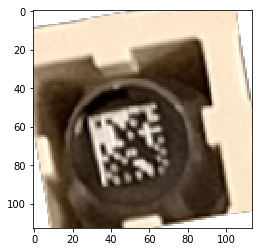

In [83]:
plt.imshow(transform.rotate(well, 10))